In [282]:
%matplotlib inline
import re

import pandas
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize, stem
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

### Загрузка данных

Загрузим датасет, и проверим, сбалансирован ли он:

In [330]:
path = 'SMSSpamCollection'
messages = pandas.read_csv(path, sep='\t',
                           names=['label', 'message'])
print(messages['label'].value_counts())
print('\n')
print(messages['label'].value_counts('normalize'))

ham     4825
spam     747
Name: label, dtype: int64


ham     0.865937
spam    0.134063
Name: label, dtype: float64


Видно, что датасет значительно перекошен в сторону не-спама -- к счастью, люди обычно получают спам значительно реже, чем в половине случаев. 

Если мы этих данных обучим *DummyClassifier*, который будем выдавать 'ham' на любое сообщение, то получим *accuracy* около 0.86. Это неплохой результат для классификатора, но совершенно бесполезно для нашей задачи.

In [4]:
cls = DummyClassifier(strategy='constant', constant='ham')
X_train, X_test, y_train, y_test = train_test_split(
    np.zeros((len(messages['label']), 1)), 
    np.array(messages['label']), 
    test_size=0.3)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
print accuracy_score(y_pred, y_test)

0.86961722488


Выберем для тренировки примерно поровну спама и не-спама:

In [77]:
def get_balanced_train_indices(messages, spam_train_part):
    train_indices = []
    spam_train_part = 0.7
    n_samples = int(spam_train_part * messages['label'].value_counts().min())
    for label in ('ham', 'spam'):
        samples = messages[messages['label'] == label].index.values
        indices = np.random.choice(samples, size=n_samples, replace=False)
        train_indices.extend(indices.tolist())
    train_indices = np.array(train_indices)
    np.random.shuffle(train_indices)
    print('{} balanced train samples prepared.'.format(len(train_indices)))
    return train_indices

In [78]:
train_indices = get_balanced_train_indices(messages, 0.7)
test_indices = np.array(list(set(range(len(messages))) - set(train_indices)))
print('{} test samples'.format(len(test_indices) + len(train_indices)))

y = np.array(messages['label'])
y = np.array([1 if label == 'spam' else 0 for label in y])
y_train, y_test = y[train_indices], y[test_indices]

1044 balanced train samples prepared.
5572 test samples


Построим фичи на основе CountVectorizer (bag-of-words) и попробуем обучить байесовскую модель:

In [91]:
X = CountVectorizer().fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + word tokenizer.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + word tokenizer.
accuracy:	0.966
f1:		0.734


### Токенизация

Добавим токенизатор:

In [95]:
class WordTokenizer(object):
    def __call__(self, string):
        tokens = re.split(r'\W', string)
        tokens = [token for token in tokens if token != '']
        return tokens
print(WordTokenizer()("Hello! You called 911, what's your concern?"))

['Hello', 'You', 'called', '911', 'what', 's', 'your', 'concern']


In [92]:
X = CountVectorizer(
    tokenizer=WordTokenizer(),
    ).fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + word tokenizer.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + word tokenizer.
accuracy:	0.972
f1:		0.768


Благодаря уменьшению размера словаря после токенизации, качество немного повысилось.
Попробуем теперь оставлять знаки препинания как отдельные токены:

In [108]:
class TokenTokenizer(object):
    def __call__(self, string):
        string = re.sub(r'(\W)', r' \1 ', string)
        tokens = string.split()
        tokens = [token for token in tokens if token != '']
        return tokens
print(TokenTokenizer()("Hello! You called 911, what's your concern?"))

['Hello', '!', 'You', 'called', '911', ',', 'what', "'", 's', 'your', 'concern', '?']


In [110]:
X = CountVectorizer(
    tokenizer=TokenTokenizer(),
    ).fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + token tokenizer.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + token tokenizer.
accuracy:	0.973
f1:		0.779


Наконец, попробуем использовать стандартный токенайзер от nltk: он тоже отделяет знаки препинания, но иначе обрабатывает притяжательные прилагательные и другие конструкции:

In [113]:
print(word_tokenize("Hello! You called 911, what's your concern?"))

['Hello', '!', 'You', 'called', '911', ',', 'what', "'s", 'your', 'concern', '?']


In [112]:
X = CountVectorizer(
    tokenizer=lambda x: word_tokenize(x),
    ).fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + nltk tokenizer.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + nltk tokenizer.
accuracy:	0.965
f1:		0.727


Умная токенизация здесь сделала только хуже: возможно, правила литературного английского плохо применимы к языку быстрой переписки.

### Стемминг и лемматизация

Попробуем добавить стемминг: в общем доступе можно найти только разные вариации SnowballStemmer/PorterStemmer. 
Поэтому ограничимся им.

In [140]:
stemmer = PorterStemmer()
for word in ('words', ',', 'flying'):
    print('Before stem: "{}", after stem: "{}:'.format(word, stemmer.stem(word)))

Before stem: "words", after stem: "word:
Before stem: ",", after stem: ",:
Before stem: "flying", after stem: "fli:


In [141]:
class StemTokenizer(TokenTokenizer):
    def __init__(self):
        self.stemmer = PorterStemmer()
        
    def __call__(self, string):
        tokens = super(StemTokenizer, self).__call__(string)
        return [self.stemmer.stem(token) for token in tokens]

In [184]:
X = CountVectorizer(
    tokenizer=StemTokenizer(),
    ).fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + stemming tokenizer.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + stemming tokenizer.
accuracy:	0.973
f1:		0.779


Разница незаметна, а вот время работы заметно увеличилось. Поэтому использовать стемминг мы не будем. 

Попробуем теперь лемматизацию на основе WordNet словарей: она должна быть менее грубой, чем стемминг. Но и значительно более бедной, а значит, это вряд ли сильно повлияет на наш, довольно специфический датасет.

In [149]:
lemmatizer = WordNetLemmatizer()
for word in ('words', ',', 'flying'):
    print('Before stem: "{}", after stem: "{}:'.format(word, lemmatizer.lemmatize(word)))

Before stem: "words", after stem: "word:
Before stem: ",", after stem: ",:
Before stem: "flying", after stem: "flying:


In [150]:
class LemmatizeTokenizer(TokenTokenizer):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        
    def __call__(self, string):
        tokens = super(WordNetLemmatizer, self).__call__(string)
        return [self.lemmatizer.lemmatize(token) for token in tokens]

In [183]:
X = CountVectorizer(
    tokenizer=StemTokenizer(),
    ).fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + lemmatize tokenizer.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + lemmatize tokenizer.
accuracy:	0.973
f1:		0.779


Действительно, изменений не видно, как и ожидалось.

### Удаление стоп-слов и пороги document frequency

Воспользуемся встроенным списком стоп-слов в CountVectorizer:

In [182]:
X = CountVectorizer(
    tokenizer=TokenTokenizer(),
    stop_words='english'
    ).fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + built-in stopwords.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + built-in stopwords.
accuracy:	0.956
f1:		0.688


Возьмем какой-нибудь [внешний список стоп-слов](https://sites.google.com/site/kevinbouge/stopwords-lists/stopwords_en.txt?attredirects=0&d=1) для английского языка и попробуем отфильтровать их перед векторизацией.

In [156]:
my_stopwords = set()
with open('stopwords_en.txt') as stopfile:
    my_stopwords = stopfile.read().split()
print(len(my_stopwords), my_stopwords[:5])

(571, ['a', "a's", 'able', 'about', 'above'])


In [181]:
cls = CountVectorizer(
    tokenizer=TokenTokenizer(),
    stop_words=my_stopwords
    )
X = cls.fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB BOW + my stopwords.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW + my stopwords.
accuracy:	0.936
f1:		0.599


Попробуем отфильтровать стоп-слова автоматически, настраивая max_df.
Для этого будем смотреть на размер словаря и постепенно вариьировать max_df.

In [170]:
for max_df in (1.0, 0.7, 0.5, 0.3, 0.2, 0.15, 0.1, 0.05):
    cls = CountVectorizer(
        tokenizer=TokenTokenizer(),
        max_df=max_df
        )
    X = cls.fit_transform(messages['message'])
    X_train, X_test = X[train_indices], X[test_indices]
    y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
    print('MultinomialNB BOW with max_df={} and vocab_size={}.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
        max_df, len(cls.vocabulary_), accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW with max_df=1.0 and vocab_size=8798.
accuracy:	0.973
f1:		0.779
MultinomialNB BOW with max_df=0.7 and vocab_size=8798.
accuracy:	0.973
f1:		0.779
MultinomialNB BOW with max_df=0.5 and vocab_size=8797.
accuracy:	0.973
f1:		0.777
MultinomialNB BOW with max_df=0.3 and vocab_size=8795.
accuracy:	0.971
f1:		0.769
MultinomialNB BOW with max_df=0.2 and vocab_size=8790.
accuracy:	0.969
f1:		0.754
MultinomialNB BOW with max_df=0.15 and vocab_size=8788.
accuracy:	0.971
f1:		0.768
MultinomialNB BOW with max_df=0.1 and vocab_size=8778.
accuracy:	0.966
f1:		0.738
MultinomialNB BOW with max_df=0.05 and vocab_size=8741.
accuracy:	0.964
f1:		0.728


Для уменьшения словаря нам приходится очень сильно занижать max_df (в документации к CountVectorizer предлагается ставить *max_df=0.7*). Это связано с тем, что тексты смск-сообщений короткие и даже общеупотребимые предлоги не используются в половине всех смсок. 

Так что данный подход не очень эффективен здесь.

Зато увеличение min_df позволяет решить проблему, с которой не могли справиться лемматизация и стемминг.
Размер словаря сильно уменьшается, пропадают редкие слова, которые все равно плохо годятся в качестве фич и растет качество.

In [176]:
for min_df in range(1, 10):
    cls = CountVectorizer(
        tokenizer=TokenTokenizer(),
        min_df=min_df
        )
    X = cls.fit_transform(messages['message'])
    X_train, X_test = X[train_indices], X[test_indices]
    y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
    print('MultinomialNB BOW with min_df={} and vocab_size={}.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
        min_df, len(cls.vocabulary_), accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW with min_df=1 and vocab_size=8798.
accuracy:	0.973
f1:		0.779
MultinomialNB BOW with min_df=2 and vocab_size=4288.
accuracy:	0.978
f1:		0.808
MultinomialNB BOW with min_df=3 and vocab_size=2887.
accuracy:	0.979
f1:		0.815
MultinomialNB BOW with min_df=4 and vocab_size=2243.
accuracy:	0.977
f1:		0.803
MultinomialNB BOW with min_df=5 and vocab_size=1876.
accuracy:	0.977
f1:		0.803
MultinomialNB BOW with min_df=6 and vocab_size=1630.
accuracy:	0.976
f1:		0.795
MultinomialNB BOW with min_df=7 and vocab_size=1444.
accuracy:	0.976
f1:		0.794
MultinomialNB BOW with min_df=8 and vocab_size=1286.
accuracy:	0.975
f1:		0.790
MultinomialNB BOW with min_df=9 and vocab_size=1167.
accuracy:	0.975
f1:		0.790


Оптимальное значение в районе 2-3: его и оставим.

### Векторизация и нграммы

Попробуем использовать другой тип векторизации: будем считать не каунты, а частоты.
Для этого возьмем TfidfVectorizer.

In [186]:
cls = TfidfVectorizer(
    )
X = cls.fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB TF-IDF BOW.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB TF-IDF BOW.
accuracy:	0.959
f1:		0.701


In [189]:
cls = TfidfVectorizer(
    tokenizer=WordTokenizer(),
    min_df=3
    )
X = cls.fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]
y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
print('MultinomialNB TF-IDF BOW + token tokenizer with min_df=3.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB TF-IDF BOW + token tokenizer with min_df=3.
accuracy:	0.973
f1:		0.777


И без дополнительной обработки, и с найденными параметрами для CountVectorizer результаты незначительно ухудшаются.

Скорее всего, это связано с тем, что MultinomialNB лучше работает именно с каунтами, а не с частотами.

Наконец, попробуем добавить нграммы в наш bow-словарь. 
Будем использовать min_df=2:

In [199]:
for max_n in range(1, 7):
    X = CountVectorizer(
        tokenizer=TokenTokenizer(),
        min_df=2,
        ngram_range=(1, max_n)
        ).fit_transform(messages['message'])
    X_train, X_test = X[train_indices], X[test_indices]
    y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)
    print('MultinomialNB BOW for 1-{} grams (min_df=2).\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
        max_n, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)))

MultinomialNB BOW for 1-1 grams (min_df=2).
accuracy:	0.978
f1:		0.808
MultinomialNB BOW for 1-2 grams (min_df=2).
accuracy:	0.981
f1:		0.829
MultinomialNB BOW for 1-3 grams (min_df=2).
accuracy:	0.983
f1:		0.846
MultinomialNB BOW for 1-4 grams (min_df=2).
accuracy:	0.983
f1:		0.845
MultinomialNB BOW for 1-5 grams (min_df=2).
accuracy:	0.985
f1:		0.854
MultinomialNB BOW for 1-6 grams (min_df=2).
accuracy:	0.983
f1:		0.834


### Решающие деревья

In [255]:
X = CountVectorizer(
    tokenizer=TokenTokenizer(),
    min_df=2,
    ngram_range=(1, 5)
    ).fit_transform(messages['message'])
X_train, X_test = X[train_indices], X[test_indices]

In [256]:
bayes_cls = MultinomialNB().fit(X_train, y_train)
y_pred_bayes = bayes_cls.predict(X_test)
y_pred_proba_bayes = bayes_cls.predict_proba(X_test)
print('Multinomial BOW.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred_bayes), f1_score(y_test, y_pred_bayes)))

Multinomial BOW.
accuracy:	0.985
f1:		0.854


In [260]:
tree_cls = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_tree = tree_cls.predict(X_test)
y_pred_proba_tree = tree_cls.predict_proba(X_test)
print('Decision tree BOW.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred_tree), f1_score(y_test, y_pred_tree)))

Decision tree BOW.
accuracy:	0.955
f1:		0.670


In [267]:
rf_cls = RandomForestClassifier(
    n_estimators=100,
    ).fit(X_train, y_train)
y_pred_rf = rf_cls.predict(X_test)
y_pred_proba_rf = rf_cls.predict_proba(X_test)
print('Random forest BOW.\naccuracy:\t{:.3f}\nf1:\t\t{:.3f}'.format(
    accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf)))

Random forest BOW.
accuracy:	0.995
f1:		0.947


Использование RandomForest дает больший рывок в качестве, чем весь препроцессинг: в силу малого размера выборки было бы целесообразно сразу использовать его. Однако, в случае больших текстов, размер bag-of-words словаря оказывается слишком большим для random forest, и препроцессинг фич становится важнее.

In [293]:
print('Bayes classification report')
print(classification_report(y_test, y_pred_bayes, target_names=['ham', 'spam']))

Bayes classification report
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      4303
       spam       0.81      0.90      0.85       225

avg / total       0.99      0.98      0.99      4528



In [294]:
print('Decision tree classification report')
print(classification_report(y_test, y_pred_tree, target_names=['ham', 'spam']))

Decision tree classification report
             precision    recall  f1-score   support

        ham       1.00      0.96      0.98      4303
       spam       0.53      0.92      0.67       225

avg / total       0.97      0.96      0.96      4528



In [295]:
print('Random forest classification report')
print(classification_report(y_test, y_pred_rf, target_names=['ham', 'spam']))

Random forest classification report
             precision    recall  f1-score   support

        ham       1.00      1.00      1.00      4303
       spam       0.99      0.91      0.95       225

avg / total       0.99      0.99      0.99      4528



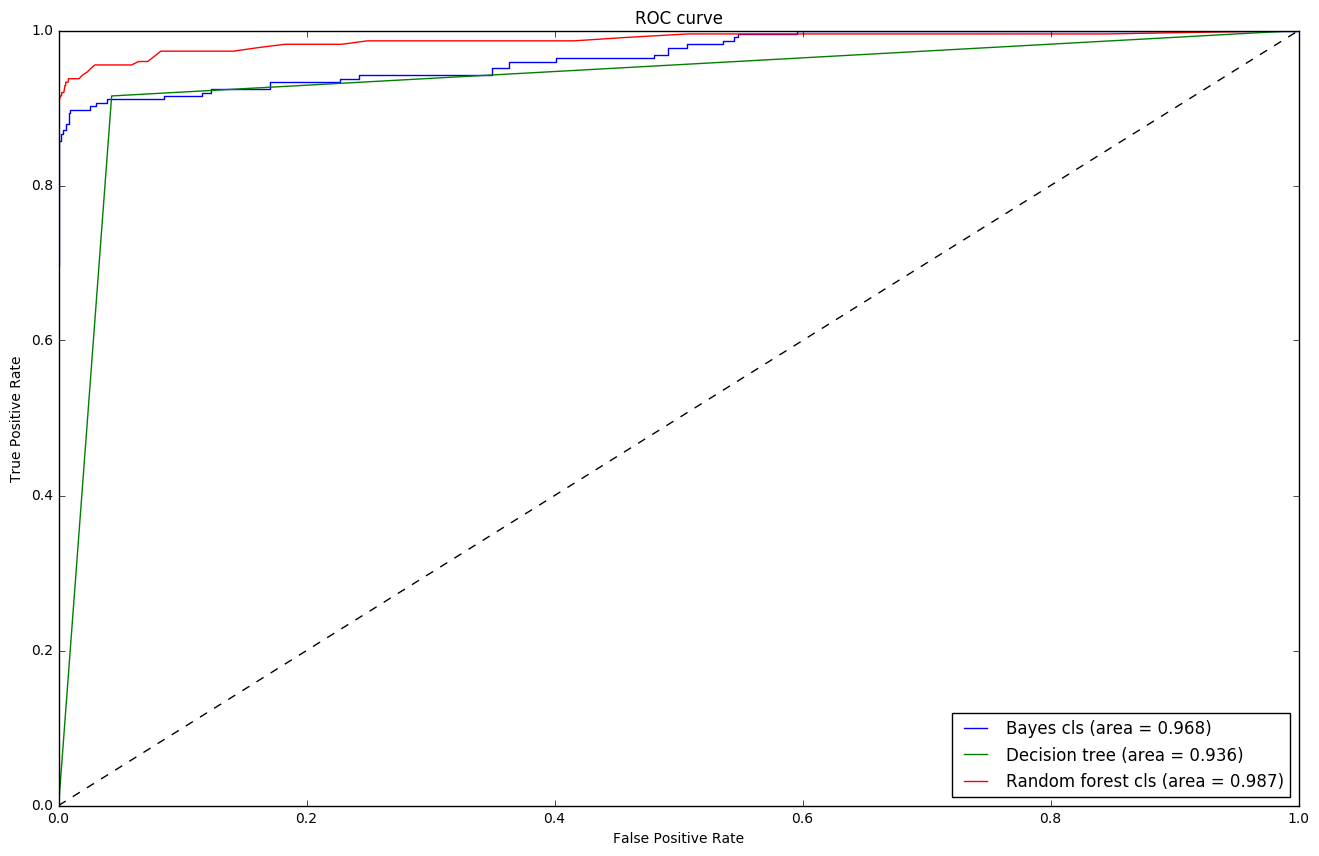

In [289]:
fpr_bayes, tpr_bayes, thresholds = roc_curve(y_test, y_pred_proba_bayes[:, 1])
roc_auc_bayes = roc_auc_score(y_test, y_pred_proba_bayes[:, 1])

fpr_tree, tpr_tree, thresholds = roc_curve(y_test, y_pred_proba_tree[:, 1])
roc_auc_tree = roc_auc_score(y_test, y_pred_proba_tree[:, 1])

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_pred_proba_rf[:, 1])
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf[:, 1])

plt.figure(figsize=(16,10))
plt.plot(fpr_bayes, tpr_bayes, label='Bayes cls (area = %0.3f)' % roc_auc_bayes)
plt.plot(fpr_tree, tpr_tree, label='Decision tree (area = %0.3f)' % roc_auc_tree)
plt.plot(fpr_rf, tpr_rf, label='Random forest cls (area = %0.3f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

Roc-кривая для решающего дерева -- ломаная из двух звеньев, как и ожидалось. Ломаные для RandomForest и NaiveBayes выглядят похоже, но RandomForest заметно лучше.

### Добавление новых признаков

Попробуем не использовать частотности слов, а сгенерировать свои собственные признаки.
Помимо предложенных признаков, добавив количество слов полностью в верхнем регистре.

In [342]:
df, df_test = train_test_split(messages, test_size=0.2)

In [375]:
import string

def caps_words(text):
    tokens = TokenTokenizer()(text)
    return len([t for t in tokens if all(c in string.uppercase for c in t)])


def add_numeric_features(df):
    df['length'] = df['message'].map(lambda text: len(text))
    df['length_CAPS'] = df['message'].map(lambda text: len([c for c in text if c in string.uppercase]))
    df['caps_words'] = df['message'].map(lambda text: caps_words(text))
    for sign in ('!.,?'):
        df['length_{}'.format(sign)] = df['message'].map(lambda text: text.count(sign))
    df['digits'] = df['message'].map(lambda text: len([c for c in text if c in '0123456789']))

In [344]:
#import warnings
#warnings.filterwarnings('ignore')
add_features(df)
df.groupby('label').describe()

caps_words       digits       length     length_!     length_,  \
label                                                                          
ham   count  3842.000000  3842.000000  3842.000000  3842.000000  3842.000000   
      mean      0.959136     0.312337    70.119209     0.170224     0.311556   
      std       2.902054     1.087813    56.600284     0.602147     0.743639   
      min       0.000000     0.000000     2.000000     0.000000     0.000000   
      25%       0.000000     0.000000    33.000000     0.000000     0.000000   
      50%       0.000000     0.000000    51.000000     0.000000     0.000000   
      75%       1.000000     0.000000    91.000000     0.000000     0.000000   
      max      37.000000    23.000000   910.000000    11.000000    10.000000   
spam  count   615.000000   615.000000   615.000000   615.000000   615.000000   
      mean      2.538211    15.821138   138.295935     0.713821     0.582114   
      std       2.793330     8.619001    29.680331     0.928759     1.088587   
      min       0.000000     0.000000    13.000000     0.000000     0.000000   
      25%       1.000000    11.000000   132.000000     0.000000     0.000000   
      50%       2.000000    16.000000   149.000000     0.000000     0.000000   
      75%       4.000000    22.000000   157.000000     1.000000     1.000000   
      max      27.000000    41.000000   224.000000     5.000000     6.000000   

                length_.     length_?  length_CAPS  
label                                               
ham   count  3842.000000  3842.000000  3842.000000  
      mean      1.962259     0.275638     4.069755  
      std       2.678733     0.629298    10.976903  
      min       0.000000     0.000000     0.000000  
      25%       0.000000     0.000000     1.000000  
      50%       1.000000     0.000000     2.000000  
      75%       3.000000     0.000000     3.000000  
      max      41.000000    12.000000   138.000000  
spam  count   615.000000   615.000000   615.000000  
      mean      2.053659     0.214634    15.234146  
      std       1.726979     0.516295    12.797361  
      min       0.000000     0.000000     0.000000  
      25%       1.000000     0.000000     7.000000  
      50%       2.000000     0.000000    13.000000  
      75%       3.000000     0.000000    20.000000  
      max      13.000000     4.000000   128.000000

Действительно, почти в каждом столбце есть существенное различие между mean для spam и mean для ham.

Соберем теперь наиболее частотные спам-слова с помощью нашего WordTokenizer (пунктуация в топе нам будет только мешаться, да и мы уже постарались ее учесть в признаках выше):

In [372]:
from collections import Counter

spam_messages = list(df[df['label'] == 'spam']['message'])
spam_messages = [WordTokenizer()(msg) for msg in spam_messages]
spam_words = [word for msg in spam_messages for word in msg]
spam_cnt = Counter(spam_words)
print('Spam top-30 most popular words:\n')
print('\n'.join(['{} : {}'.format(word, count) for word, count in cnt.most_common(30)]))

spam_messages = list(df[df['label'] == 'spam']['message'])
spam_messages = [WordTokenizer()(msg) for msg in spam_messages]
spam_words = [word for msg in spam_messages for word in msg]
spam_cnt = Counter(spam_words)

Spam top-30 most popular words:

to : 501
a : 284
2 : 172
call : 160
or : 153
you : 147
for : 145
your : 145
the : 140
on : 120
now : 119
Call : 119
4 : 118
is : 112
FREE : 102
have : 99
and : 97
1 : 94
from : 93
with : 90
ur : 90
U : 90
of : 75
mobile : 75
www : 74
are : 67
text : 67
in : 64
To : 63
txt : 62


Здесь уже есть неплохие признаки рекламных сообщений (например 'FREE' и 'Call' в топе), но большую часть все же составлят стоп-слова. Можно было бы отфильтровать используя уже скачанный нами список стоп-слов.

Но вместо этого будет лучше посмотреть на топ частотных слов в ham messages и пересечь эти два множества.
Для этого возьмем, к примеру топ-100 спам-слов и топ-500 ham слов.

In [371]:
ham_messages = list(df[df['label'] == 'ham']['message'])
ham_messages = [WordTokenizer()(msg) for msg in ham_messages]
ham_words = [word for msg in ham_messages for word in msg]
ham_cnt = Counter(ham_words)
ham_top_500 = set(word for word, count in ham_cnt.most_common(500))

print('Spam top-100 - ham top-500 most popular words:\n')

print('\n'.join(['{} : {}'.format(w, c) for w, c in spam_cnt.most_common(100) if w not in ham_top_500]))

Spam top-100 - ham top-500 most popular words:

Call : 119
FREE : 102
mobile : 75
www : 74
To : 63
txt : 62
claim : 62
T : 61
prize : 59
Txt : 59
150p : 58
STOP : 52
50 : 48
cash : 47
16 : 45
18 : 45
Nokia : 43
com : 42
uk : 42
service : 41
contact : 41
won : 41
co : 41
500 : 39
Free : 38
NOW : 37
Text : 37
100 : 35
Cs : 35
1000 : 35
per : 35
tone : 33
URGENT : 33
Reply : 32
line : 30
customer : 30
awarded : 29
shows : 28
draw : 28
Get : 28
win : 26


Вот этот список уже значительно больше похож на рекламные слова! 
Уберем отсюда числа, а все остальные слова запишем в список фич.

In [384]:
spam_words = [w for w, c in spam_cnt.most_common(100) if w not in ham_top_500 and not w.isdigit()]

def add_word_features(df):
    for word in spam_words:
        df['spamword_{}'.format(word)] = df['message'].map(lambda text: int(word in text))
    df['spamword_count'] = df['message'].map(lambda text : sum(int(word in text) for word in spam_words))

Сформируем train_set и test_set и протестируем наши старые модели.

In [390]:
add_word_features(df)
add_features(df_test)
add_word_features(df_test)

In [402]:
X_train = np.array(df.ix[:, 2:])
X_test = np.array(df_test.ix[:, 2:])
y_train = np.array([1 if l == 'spam' else 0 for l in df['label']])
y_test = np.array([1 if l == 'spam' else 0 for l in df_test['label']])

In [409]:
bayes_cls = MultinomialNB().fit(X_train, y_train)
y_pred_bayes = bayes_cls.predict(X_test)
y_pred_proba_bayes = bayes_cls.predict_proba(X_test)
print('Naive bayes classification report')
print(classification_report(y_test, y_pred_bayes, target_names=['ham', 'spam']))

Naive bayes classification report
             precision    recall  f1-score   support

        ham       0.98      0.97      0.98       983
       spam       0.82      0.87      0.84       132

avg / total       0.96      0.96      0.96      1115



In [408]:
tree_cls = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_tree = tree_cls.predict(X_test)
y_pred_proba_tree = tree_cls.predict_proba(X_test)
print('Decision tree classification report')
print(classification_report(y_test, y_pred_tree, target_names=['ham', 'spam']))

Decision tree classification report
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99       983
       spam       0.92      0.92      0.92       132

avg / total       0.98      0.98      0.98      1115



In [410]:
rf_cls = RandomForestClassifier(
    n_estimators=100,
    ).fit(X_train, y_train)
y_pred_rf = rf_cls.predict(X_test)
y_pred_proba_rf = rf_cls.predict_proba(X_test)
print('Random forest classification report')
print(classification_report(y_test, y_pred_rf, target_names=['ham', 'spam']))

Random forest classification report
             precision    recall  f1-score   support

        ham       0.98      1.00      0.99       983
       spam       0.99      0.89      0.94       132

avg / total       0.99      0.99      0.99      1115



В итоге, качество байесовского классификатора немного ухудшилось по сравнению с предыдущим замером -- он более оптимизирован для работы с word counts, чем с произвольными категориальными признаками.

Зато решающее дерево теперь показывает результат куда лучше, чем байесовский классификатор, а random forest опять близок к идеальной классификации.